<h2>Xây dựng mô hình dự đoán các trận đấu</h2>


<h5>Phần này sẽ kết hợp các kỹ thuật và phương pháp trong Machine Learning để xây dựng một mô hình dự đoán kết quả của các trận đấu trong tương lai, sử dụng Spark Machine Learning</h5>

<h4>1. Các thư viện và model được sử dụng</h4>

Các thư viện bên ngoài 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


Các thư viện trong Spark Machine Learning

In [2]:
#import findspark
#import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, lit

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.feature import OneHotEncoder,StringIndexer,VectorAssembler
#from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.stat import ChiSquareTest
from pyspark.sql.types import *

<h4>2. Phân tích dữ liệu</h4>

Lấy dữ liệu đã được chuẩn bị cho xây dựng model

In [3]:
dataset_model = pd.read_csv('./data/matchs_dataset_model.csv',encoding='utf-8-sig')
dataset_model

,Match_Id,Match_Date,Home_Team,Home_Manager,Home_Captain,Home_Formation,Home_Possession,Home_Fouls,Home_Corners,Home_Crosses,...,Away_Att_Take_Ons,Away_Succ_Take_Ons,Home_Attack,Home_Midfield,Home_Defense,Away_Attack,Away_Midfield,Away_Defense,Home_Score,Away_Score
0,8c6293a3,2023-10-23,Tottenham Hotspur,Ange Postecoglou,Son Heung-min,4231,65.0,9.0,8.5,21.0,...,15.0,8.5,78.909091,79.636364,77.000000,74.400000,76.588235,74.875000,2,0
1,7efcc598,2023-10-22,Aston Villa,Unai Emery,John McGinn,442,46.0,14.0,5.5,18.5,...,11.5,7.5,72.714286,77.944444,78.333333,74.000000,78.916667,77.800000,4,1
2,d95b42eb,2023-10-21,Sheffield United,Paul Heckingbottom,Oliver Norwood,442,44.0,9.5,4.0,14.5,...,20.0,10.5,69.400000,71.615385,69.181818,75.833333,79.588235,79.800000,1,2
3,21625dde,2023-10-21,Newcastle United,Eddie Howe,Jamaal Lascelles,433,58.5,12.5,3.5,15.5,...,20.0,9.5,78.100000,80.888889,75.272727,72.833333,71.333333,76.857143,4,0
4,e747ddb3,2023-10-21,Liverpool,Jürgen Klopp,Virgil van Dijk,433,45.0,18.5,3.0,9.5,...,25.0,11.0,82.800000,80.846154,79.125000,74.800000,75.200000,74.692308,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,f74a4680,2018-09-01,Manchester City,Pep Guardiola,David Silva,4132,73.5,8.5,9.5,27.0,...,8.5,2.5,85.250000,83.250000,83.000000,75.750000,73.230769,73.333333,2,1
1930,95fc9c84,2018-09-01,Chelsea,Maurizio Sarri,César Azpilicueta,433,71.0,10.0,5.0,19.0,...,18.5,9.0,85.500000,82.000000,81.750000,74.500000,75.538462,74.666667,2,0
1931,51055c21,2018-09-01,Brighton & Hove Albion,Chris Hughton,Lewis Dunk,4411,32.5,15.0,4.0,12.0,...,12.5,7.5,76.000000,74.357143,75.666667,75.250000,76.909091,73.000000,2,2
1932,db5e61cc,2018-08-25,Liverpool,Jürgen Klopp,James Milner,433,63.5,13.5,6.0,22.0,...,7.0,4.5,84.833333,81.555556,80.500000,76.000000,74.357143,75.000000,1,0


Thêm attribute Result thể hiện kết quả trận đấu cho đội sân nhà với 3 trường hợp: Win, Draw, Lose

In [4]:
list_result = ['Win' if home_score > away_score 
               else 'Draw' if home_score == away_score 
               else 'Lose' for home_score, away_score 
               in zip(dataset_model['Home_Score'], dataset_model['Away_Score'])]

In [5]:
dataset_model['Result'] = list_result
dataset_model

,Match_Id,Match_Date,Home_Team,Home_Manager,Home_Captain,Home_Formation,Home_Possession,Home_Fouls,Home_Corners,Home_Crosses,...,Away_Succ_Take_Ons,Home_Attack,Home_Midfield,Home_Defense,Away_Attack,Away_Midfield,Away_Defense,Home_Score,Away_Score,Result
0,8c6293a3,2023-10-23,Tottenham Hotspur,Ange Postecoglou,Son Heung-min,4231,65.0,9.0,8.5,21.0,...,8.5,78.909091,79.636364,77.000000,74.400000,76.588235,74.875000,2,0,Win
1,7efcc598,2023-10-22,Aston Villa,Unai Emery,John McGinn,442,46.0,14.0,5.5,18.5,...,7.5,72.714286,77.944444,78.333333,74.000000,78.916667,77.800000,4,1,Win
2,d95b42eb,2023-10-21,Sheffield United,Paul Heckingbottom,Oliver Norwood,442,44.0,9.5,4.0,14.5,...,10.5,69.400000,71.615385,69.181818,75.833333,79.588235,79.800000,1,2,Lose
3,21625dde,2023-10-21,Newcastle United,Eddie Howe,Jamaal Lascelles,433,58.5,12.5,3.5,15.5,...,9.5,78.100000,80.888889,75.272727,72.833333,71.333333,76.857143,4,0,Win
4,e747ddb3,2023-10-21,Liverpool,Jürgen Klopp,Virgil van Dijk,433,45.0,18.5,3.0,9.5,...,11.0,82.800000,80.846154,79.125000,74.800000,75.200000,74.692308,2,0,Win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,f74a4680,2018-09-01,Manchester City,Pep Guardiola,David Silva,4132,73.5,8.5,9.5,27.0,...,2.5,85.250000,83.250000,83.000000,75.750000,73.230769,73.333333,2,1,Win
1930,95fc9c84,2018-09-01,Chelsea,Maurizio Sarri,César Azpilicueta,433,71.0,10.0,5.0,19.0,...,9.0,85.500000,82.000000,81.750000,74.500000,75.538462,74.666667,2,0,Win
1931,51055c21,2018-09-01,Brighton & Hove Albion,Chris Hughton,Lewis Dunk,4411,32.5,15.0,4.0,12.0,...,7.5,76.000000,74.357143,75.666667,75.250000,76.909091,73.000000,2,2,Draw
1932,db5e61cc,2018-08-25,Liverpool,Jürgen Klopp,James Milner,433,63.5,13.5,6.0,22.0,...,4.5,84.833333,81.555556,80.500000,76.000000,74.357143,75.000000,1,0,Win


In [6]:
dataset_model.to_csv('./data/matchs_with_result.csv',index=False,encoding='utf-8-sig')

Kiểm tra số row thiếu dữ liệu, số thuộc tính input từ Home_Team đến Away_Defense

In [7]:
nan_rows = dataset_model.isna().sum(axis=1)
num_nan_rows = len(nan_rows[nan_rows > 0])
print("Tổng số trận:", len(dataset_model))
print("Số trận bị thiếu dữ liệu:", num_nan_rows)
print("Số thuộc tính input:", (dataset_model.columns.get_loc("Away_Defense") 
                               - dataset_model.columns.get_loc("Home_Team")) + 1)

Tổng số trận: 1934
Số trận bị thiếu dữ liệu: 0
Số thuộc tính input: 88


Trực quan hóa dữ liệu một vài thuộc tính

<Axes: >

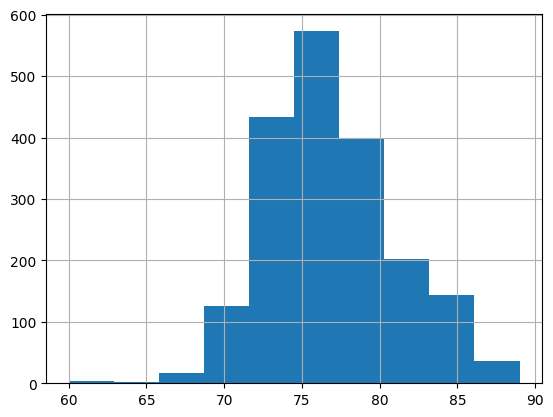

In [8]:
dataset_model['Home_Attack'].hist()

- Chỉ số tấn công của các team tập trung nhiều ở mức 75 - 80

<Axes: >

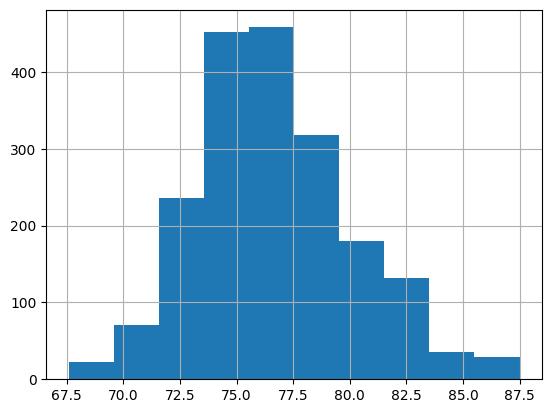

In [9]:
dataset_model['Home_Midfield'].hist()

- Chỉ số hàng tiền vệ ở các team có mật độ dày hơn và tập trung nhiều từ 72.5 - 77.5

<Axes: >

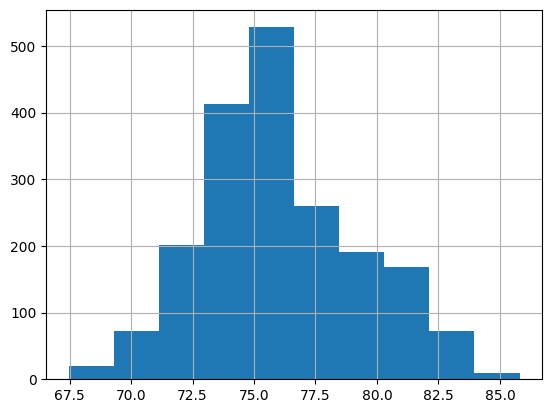

In [10]:
dataset_model['Home_Defense'].hist()

- Chỉ số phòng thủ của các team tập trung nhiều ở mức từ 72.5 - 77.5

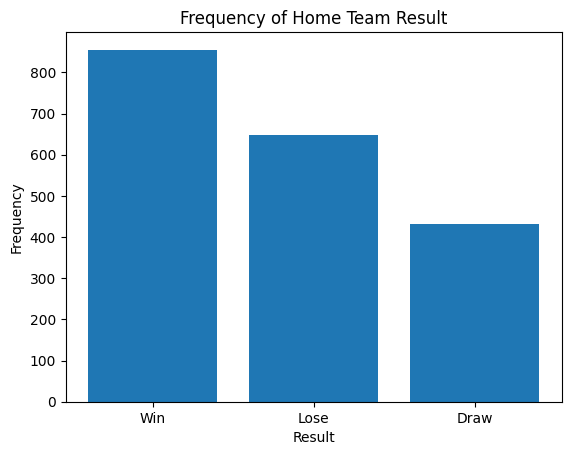

In [11]:
result_frequency = dataset_model['Result'].value_counts()

plt.bar(result_frequency.index, result_frequency.values)
plt.xlabel('Result')
plt.ylabel('Frequency')
plt.title('Frequency of Home Team Result')
plt.show()

<h4>3. Kiểm tra mối tương quan, biến đổi thuộc tính</h4>

Khởi chạy một phiên làm việc với SparkSession

In [12]:
spark = (SparkSession
         .builder
         .appName("Classifications Technique")
         .getOrCreate())

In [13]:
matches = (spark.read
            .option("HEADER", True)
            .option("inferSchema", True)
            .csv("./data/matchs_with_result.csv")
           )
matches.show(5)

+--------+----------+-----------------+------------------+----------------+--------------+---------------+----------+------------+------------+----------------+---------------+-------------+---------------+--------------+---------------+------------------------+------------+--------+--------+-------+-----------+-------+--------+---------+---------+------------+--------+--------+-----------+------------------+------------------+------------------+--------+--------+---------------+---------------+-----------------------+----------------+--------------------+-----------------+-----------------+------------------+-----------------+------------+---------------+--------------+---------------+----------+------------+------------+----------------+---------------+-------------+---------------+--------------+---------------+------------------------+------------+--------+--------+-------+-----------+-------+--------+---------+---------+------------+--------+--------+-----------+------------------

Sử dụng phương pháp One-hot Encoding để biến đổi một số thuộc tính sang numeric

In [14]:
#Attributes không dùng tới
unused_cols = ['Match_Id', 'Match_Date', 'Home_Manager', 'Home_Captain', 
               'Away_Manager', 'Away_Captain', 'Home_Score', 'Away_Score']
#Output
output_cols = ['Result']

- Chọn các input và các input cần được One-hot Encoding

In [15]:
input_cols = [column for column in matches.columns 
              if column not in output_cols and column not in unused_cols]
encode_cols = ['Home_Team','Away_Team','Home_Formation','Away_Formation']

In [16]:
def EncodedData(matches, unused_cols, output_cols, encode_cols):
    #String Indexer
    indexer = StringIndexer(inputCols=encode_cols, outputCols = [encode_col+ "_Index" for encode_col in encode_cols])
    encoded_df = indexer.fit(matches).transform(matches)

    #OneHot Encoder
    encodeer = OneHotEncoder(inputCols=[encode_col+"_Index" for encode_col in encode_cols],
                             outputCols=[encode_col+"_Onehot" for encode_col in encode_cols])
    encoded_df = encodeer.fit(encoded_df).transform(encoded_df)

    #Lấy ra những cột bị Index
    indexed_cols = [encode_col +"_Index" for encode_col in encode_cols]

    #Những cột được assembled là những cột không nằm trong unused_cols và indexed_cols và encode_cols và output_cols
    vector_assembled_input_cols = [col for col in encoded_df.columns 
                                            if col not in unused_cols
                                            and col not in indexed_cols
                                            and col not in encode_cols
                                            and col not in output_cols
                                            ]
    assembler = VectorAssembler(inputCols=vector_assembled_input_cols,outputCol="Features")
    encoded_df = assembler.transform(encoded_df.select('*'))
    return encoded_df

- Tập data sau quá trình One-hot Encoding

In [17]:
encoded_matches = EncodedData(matches,unused_cols,output_cols,encode_cols)
encoded_matches.show()

+--------+----------+--------------------+-------------------+------------------+--------------+---------------+----------+------------+------------+----------------+---------------+-------------+---------------+--------------+---------------+------------------------+------------+--------+--------+-------+-----------+-------+--------+---------+---------+------------+--------+--------+-----------+------------------+------------------+------------------+--------+--------+---------------+---------------+-----------------------+----------------+--------------------+-----------------+-----------------+------------------+--------------------+-------------------+------------------+--------------+---------------+----------+------------+------------+----------------+---------------+-------------+---------------+--------------+---------------+------------------------+------------+--------+--------+-------+-----------+-------+--------+---------+---------+------------+--------+--------+-----------

In [18]:
encoded_matches.dtypes

[('Match_Id', 'string'),
 ('Match_Date', 'date'),
 ('Home_Team', 'string'),
 ('Home_Manager', 'string'),
 ('Home_Captain', 'string'),
 ('Home_Formation', 'int'),
 ('Home_Possession', 'double'),
 ('Home_Fouls', 'double'),
 ('Home_Corners', 'double'),
 ('Home_Crosses', 'double'),
 ('Home_Aerials_Won', 'double'),
 ('Home_Clearances', 'double'),
 ('Home_Offsides', 'double'),
 ('Home_Goal_Kicks', 'double'),
 ('Home_Throw_Ins', 'double'),
 ('Home_Long_Balls', 'double'),
 ('Home_Total_Players_Stats', 'double'),
 ('Home_Minutes', 'double'),
 ('Home_Gls', 'double'),
 ('Home_Ast', 'double'),
 ('Home_PK', 'double'),
 ('Home_PK_Att', 'double'),
 ('Home_Sh', 'double'),
 ('Home_SoT', 'double'),
 ('Home_CrdY', 'double'),
 ('Home_CrdR', 'double'),
 ('Home_Touches', 'double'),
 ('Home_Tkl', 'double'),
 ('Home_Int', 'double'),
 ('Home_Blocks', 'double'),
 ('Home_xG', 'double'),
 ('Home_npxG', 'double'),
 ('Home_xAG', 'double'),
 ('Home_SCA', 'double'),
 ('Home_GCA', 'double'),
 ('Home_Cmp_Passes', 'doub

Thêm attribute Label ứng với 3 nhãn Result: Win (0.0), Lose (1.0), Draw (2.0)

In [19]:
class_indexer = StringIndexer(inputCol = 'Result', outputCol = 'Label')

encoded_matches_label = class_indexer.fit(encoded_matches).transform(encoded_matches)

encoded_matches_label.show(5)

+--------+----------+-----------------+------------------+----------------+--------------+---------------+----------+------------+------------+----------------+---------------+-------------+---------------+--------------+---------------+------------------------+------------+--------+--------+-------+-----------+-------+--------+---------+---------+------------+--------+--------+-----------+------------------+------------------+------------------+--------+--------+---------------+---------------+-----------------------+----------------+--------------------+-----------------+-----------------+------------------+-----------------+------------+---------------+--------------+---------------+----------+------------+------------+----------------+---------------+-------------+---------------+--------------+---------------+------------------------+------------+--------+--------+-------+-----------+-------+--------+---------+---------+------------+--------+--------+-----------+------------------

Kiểm tra mối tương quan

In [20]:
selected_data = encoded_matches_label.select("Features", "Label")

test_result = ChiSquareTest.test(selected_data, 
                                 'Features', 
                                 'Label')

In [21]:
test_result.show()

+--------------------+--------------------+--------------------+
|             pValues|    degreesOfFreedom|          statistics|
+--------------------+--------------------+--------------------+
|[0.01389492244566...|[210, 64, 54, 140...|[257.624487692727...|
+--------------------+--------------------+--------------------+



<h4>4. Xây dựng mô hình dự đoán với phương pháp Classification</h4>

Các function hỗ trợ cho việc xây dựng tập train, test

- Function Reduce_Matches() loại bỏ 20 trận đầu cho tập dữ liệu với mỗi lần gọi

In [22]:
def Reduce_Matches(matches_df):

    matches_df = matches_df.withColumn("id", monotonically_increasing_id())

    filtered_data = matches_df.filter(matches_df.id >= 10)
    filtered_data = filtered_data.drop("id")

    return filtered_data

- Function Train_Dataset() trả về tập train
- Funtion Test_Dataset() trả về tập test với 20 trận mới nhất (20 row đầu tiên)

In [23]:
def Train_Dataset(matches_df): 

    test_count = 10

    encoded_test_matches = matches_df.limit(test_count)
    encoded_train_matches = matches_df.subtract(encoded_test_matches)
    
    return encoded_train_matches

def Test_Dataset(matches_df): 

    test_count = 10

    encoded_test_matches = matches_df.limit(test_count)
    #encoded_train_matches = matches_df.subtract(encoded_test_matches)
    
    return encoded_test_matches

Funtion hỗ trợ các phương pháp đánh giá cho model

In [24]:
def Measure_Function(predictions, measure):

    evaluator = MulticlassClassificationEvaluator(labelCol="Label")

    measure_method = evaluator.evaluate(predictions, {evaluator.metricName: measure})

    return measure_method

    #print("Accuracy = %g" % accuracy)
    #print("Test Error = %g" % (1.0 - accuracy))

<h4>Logistic Regression</h4>

- Xây dựng model dựa vào tập train

In [25]:
def LogisticRegression_Func(X_train):
    logit = LogisticRegression(featuresCol = "Features", labelCol = "Label")

    logitModel = logit.fit(X_train)

    return logitModel

* Áp dụng model trên tập test

In [26]:
def LogitRegres_Predictions(logitModel, X_test):

    predictions = logitModel.transform(X_test)
    
    return predictions

* Sử dụng phương pháp Cross Validation lần lượt dự đoán 10 trận mới nhất cho mỗi lần thực thi

In [27]:
encoded_matches.count()

1934

In [28]:
matches_df = encoded_matches_label
list_accuracy = []
list_recall = []
list_f1_score = []
list_precision = []
for i in range(0,30):

    X_train = Train_Dataset(matches_df)
    X_train = X_train.select('Features', 'Label')

    X_test = Test_Dataset(matches_df)
    X_test = X_test.select('Features', 'Label')

    logitModel = LogisticRegression_Func(X_train)
    predictions = LogitRegres_Predictions(logitModel, X_test)

    accuracy = Measure_Function(predictions, "accuracy")
    recall = Measure_Function(predictions, "weightedRecall")
    f1_score = Measure_Function(predictions, "f1")
    precision = Measure_Function(predictions, "weightedPrecision")

    #print("Accuracy = %g" % accuracy)

    list_accuracy.append(accuracy)
    list_recall.append(recall)
    list_f1_score.append(f1_score)
    list_precision.append(precision)

    matches_df = Reduce_Matches(matches_df)

* Đánh giá model với phương pháp Accuracy

Accuracy 30 times =  [0.8, 0.6, 0.2, 0.7, 0.5, 0.7, 0.6, 0.7, 0.5, 0.6, 0.3, 0.8, 0.4, 0.7, 0.5, 0.5, 0.3, 0.5, 0.5, 0.8, 0.7, 0.5, 0.5, 0.6, 0.3, 0.2, 0.5, 0.6, 0.3, 0.5]


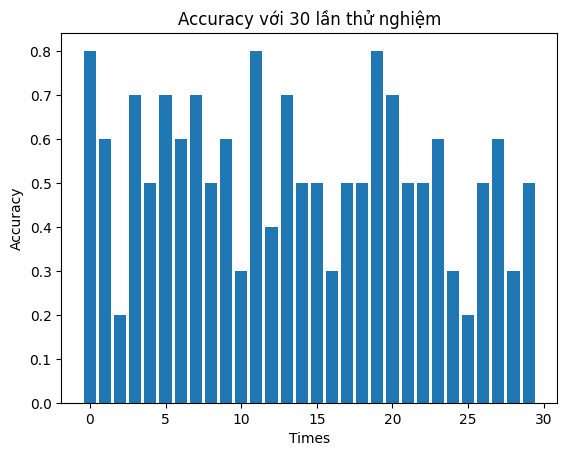

In [29]:
print("Accuracy 30 times = ", list_accuracy)
x = range(len(list_accuracy))
plt.bar(x, list_accuracy)
plt.xlabel('Times')
plt.ylabel('Accuracy')
plt.title('Accuracy với 30 lần thử nghiệm')
plt.show()

* Đánh giá model với phương pháp Recall

In [30]:
print("Recall 5 times = ", list_recall)

Recall 5 times =  [0.8, 0.6000000000000001, 0.2, 0.7000000000000001, 0.5, 0.7, 0.6, 0.7, 0.5, 0.6, 0.30000000000000004, 0.8, 0.4, 0.7, 0.5, 0.5, 0.30000000000000004, 0.5, 0.5, 0.8, 0.7, 0.5, 0.5, 0.6, 0.30000000000000004, 0.2, 0.5, 0.6000000000000001, 0.3, 0.5]


* Đánh giá model với phương pháp F1_Score

In [31]:
print("F1_Score 5 times = ", list_f1_score)

F1_Score 5 times =  [0.7809523809523808, 0.45333333333333337, 0.2138888888888889, 0.6699999999999999, 0.4685714285714286, 0.6246153846153847, 0.6757575757575757, 0.7384615384615385, 0.48142857142857143, 0.54, 0.24, 0.8177777777777779, 0.42727272727272725, 0.69, 0.49696969696969695, 0.51, 0.28714285714285714, 0.5285714285714286, 0.48, 0.8038095238095239, 0.7, 0.5, 0.6666666666666666, 0.5545454545454545, 0.25, 0.1523809523809524, 0.5272727272727273, 0.5622222222222223, 0.35, 0.44999999999999996]


* Đánh giá model với phương pháp Precision

In [32]:
print("Precision 5 times = ", list_precision)

Precision 5 times =  [0.8500000000000001, 0.3666666666666667, 0.24666666666666665, 0.7666666666666666, 0.4666666666666667, 0.6125, 0.9199999999999999, 0.7833333333333334, 0.67, 0.525, 0.2, 0.9, 0.45999999999999996, 0.719047619047619, 0.5333333333333333, 0.5833333333333334, 0.4066666666666666, 0.5666666666666667, 0.6666666666666667, 0.875, 0.7, 0.5, 1.0, 0.5166666666666667, 0.36666666666666664, 0.125, 0.61, 0.845, 0.42000000000000004, 0.42000000000000004]


In [33]:
logistic_regress_metrics = [sum(list_accuracy) / len(list_accuracy),
                            sum(list_recall) / len(list_recall),
                            sum(list_f1_score) / len(list_f1_score),
                            sum(list_precision) / len(list_precision)]
logistic_regress_metrics

[0.53, 0.53, 0.5213880378880378, 0.5873849206349208]

<h4>Decision Tree</h4>

In [34]:
encoded_matches.count()

1934

In [35]:
def DecisionTree_Func(X_train):
    deci = DecisionTreeClassifier(featuresCol = "Features", labelCol = "Label")

    deciModel = deci.fit(X_train)

    return deciModel

In [36]:
def DecisionTree_Predictions(deciModel, X_test):

    predictions = deciModel.transform(X_test)
    
    return predictions

In [37]:
matches_df = encoded_matches_label

list_accuracy = []
list_recall = []
list_f1_score = []
list_precision = []
for i in range(0,30):

    X_train = Train_Dataset(matches_df)
    X_train = X_train.select('Features', 'Label')

    X_test = Test_Dataset(matches_df)
    X_test = X_test.select('Features', 'Label')

    logitModel = DecisionTree_Func(X_train)
    predictions = DecisionTree_Predictions(logitModel, X_test)

    accuracy = Measure_Function(predictions, "accuracy")
    recall = Measure_Function(predictions, "weightedRecall")
    f1_score = Measure_Function(predictions, "f1")
    precision = Measure_Function(predictions, "weightedPrecision")

    #print("Accuracy = %g" % accuracy)

    list_accuracy.append(accuracy)
    list_recall.append(recall)
    list_f1_score.append(f1_score)
    list_precision.append(precision)

    matches_df = Reduce_Matches(matches_df)

- Đánh giá model lần lượt với các độ đo Accuracy, Recall, F1-Score, Precision

Accuracy 30 times =  [0.6, 0.5, 0.4, 0.4, 0.4, 0.2, 0.3, 0.5, 0.5, 0.4, 0.5, 0.5, 0.9, 0.5, 0.5, 0.5, 0.7, 0.7, 0.3, 0.5, 0.3, 0.6, 0.5, 0.6, 0.6, 0.3, 0.4, 0.4, 0.5, 0.4]


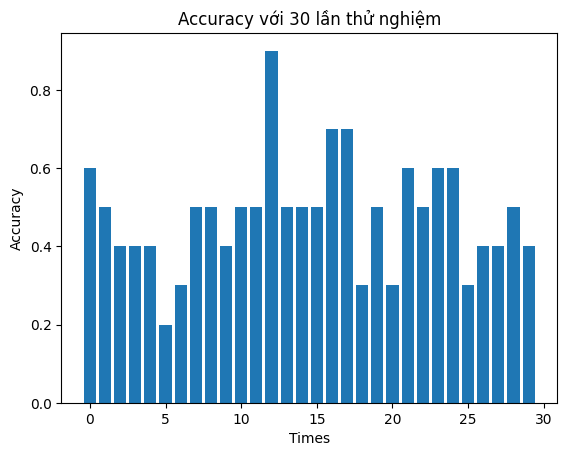

In [38]:
print("Accuracy 30 times = ", list_accuracy)
x = range(len(list_accuracy))
plt.bar(x, list_accuracy)
plt.xlabel('Times')
plt.ylabel('Accuracy')
plt.title('Accuracy với 30 lần thử nghiệm')
plt.show()

In [39]:
decision_tree_metrics = [sum(list_accuracy) / len(list_accuracy),
                            sum(list_recall) / len(list_recall),
                            sum(list_f1_score) / len(list_f1_score),
                            sum(list_precision) / len(list_precision)]
decision_tree_metrics

[0.4800000000000001,
 0.4800000000000001,
 0.4592987382987383,
 0.4952433862433862]

<h4>Naive Bayes</h4>

In [40]:
def NaiveBayes_Func(X_train):
    naive_bayes = NaiveBayes(featuresCol = "Features", labelCol = "Label")

    naive_bayes_Model = naive_bayes.fit(X_train)

    return naive_bayes_Model

In [41]:
def NaiveBayes_Predictions(naive_bayes_Model, X_test):

    predictions = naive_bayes_Model.transform(X_test)
    
    return predictions

In [42]:
matches_df = encoded_matches_label

list_accuracy = []
list_recall = []
list_f1_score = []
list_precision = []
for i in range(0,30):

    X_train = Train_Dataset(matches_df)
    X_train = X_train.select('Features', 'Label')

    X_test = Test_Dataset(matches_df)
    X_test = X_test.select('Features', 'Label')

    logitModel = NaiveBayes_Func(X_train)
    predictions = NaiveBayes_Predictions(logitModel, X_test)

    accuracy = Measure_Function(predictions, "accuracy")
    recall = Measure_Function(predictions, "weightedRecall")
    f1_score = Measure_Function(predictions, "f1")
    precision = Measure_Function(predictions, "weightedPrecision")

    #print("Accuracy = %g" % accuracy)

    list_accuracy.append(accuracy)
    list_recall.append(recall)
    list_f1_score.append(f1_score)
    list_precision.append(precision)

    matches_df = Reduce_Matches(matches_df)

- Đánh giá model lần lượt với các độ đo Accuracy, Recall, F1-Score, Precision

Accuracy 30 times =  [0.5, 0.6, 0.3, 0.4, 0.6, 0.5, 0.5, 0.7, 0.4, 0.4, 0.6, 0.6, 0.3, 0.8, 0.7, 0.6, 0.5, 0.5, 0.4, 0.3, 0.3, 0.4, 0.6, 0.4, 0.5, 0.2, 0.5, 0.4, 0.2, 0.6]


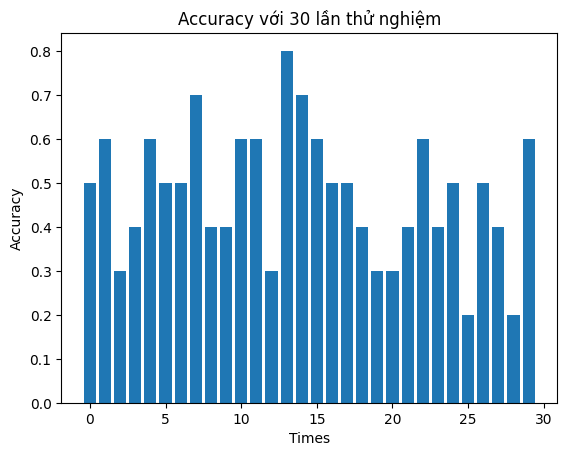

In [43]:
print("Accuracy 30 times = ", list_accuracy)
x = range(len(list_accuracy))
plt.bar(x, list_accuracy)
plt.xlabel('Times')
plt.ylabel('Accuracy')
plt.title('Accuracy với 30 lần thử nghiệm')
plt.show()

In [44]:
naive_bayes_metrics = [sum(list_accuracy) / len(list_accuracy),
                            sum(list_recall) / len(list_recall),
                            sum(list_f1_score) / len(list_f1_score),
                            sum(list_precision) / len(list_precision)]
naive_bayes_metrics

[0.4766666666666667,
 0.47666666666666674,
 0.4729931549931551,
 0.5229126984126984]

<h4>Random Forest</h4>

In [45]:
def Random_Forest_Func(X_train):
    random_forest = RandomForestClassifier(featuresCol = "Features", labelCol = "Label")

    random_forest_Model = random_forest.fit(X_train)

    return random_forest_Model

In [46]:
def Random_Forest_Predictions(random_forest_Model, X_test):

    predictions = random_forest_Model.transform(X_test)
    
    return predictions

In [47]:
matches_df = encoded_matches_label

list_accuracy = []
list_recall = []
list_f1_score = []
list_precision = []
for i in range(0,30):

    X_train = Train_Dataset(matches_df)
    X_train = X_train.select('Features', 'Label')

    X_test = Test_Dataset(matches_df)
    X_test = X_test.select('Features', 'Label')

    random_forest_Model = Random_Forest_Func(X_train)
    predictions = Random_Forest_Predictions(random_forest_Model, X_test)

    accuracy = Measure_Function(predictions, "accuracy")
    recall = Measure_Function(predictions, "weightedRecall")
    f1_score = Measure_Function(predictions, "f1")
    precision = Measure_Function(predictions, "weightedPrecision")

    #print("Accuracy = %g" % accuracy)

    list_accuracy.append(accuracy)
    list_recall.append(recall)
    list_f1_score.append(f1_score)
    list_precision.append(precision)

    matches_df = Reduce_Matches(matches_df)

- Đánh giá model lần lượt với các độ đo Accuracy, Recall, F1-Score, Precision

Accuracy 30 times =  [0.7, 0.6, 0.4, 0.5, 0.6, 0.5, 0.6, 0.8, 0.4, 0.6, 0.5, 0.6, 0.8, 0.9, 0.6, 0.5, 0.6, 0.5, 0.5, 0.5, 0.5, 0.6, 0.9, 0.7, 0.5, 0.4, 0.3, 0.5, 0.4, 0.5]


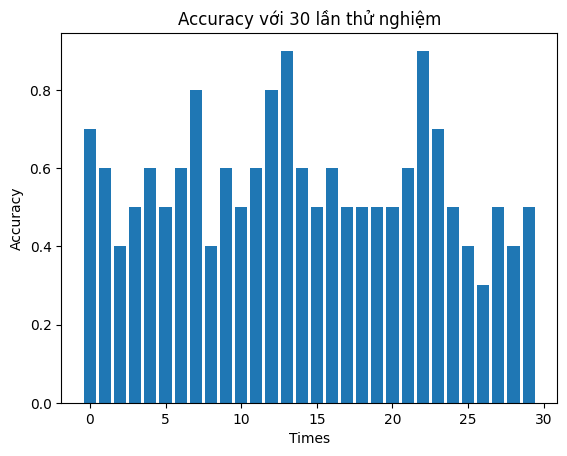

In [48]:
print("Accuracy 30 times = ", list_accuracy)
x = range(len(list_accuracy))
plt.bar(x, list_accuracy)
plt.xlabel('Times')
plt.ylabel('Accuracy')
plt.title('Accuracy với 30 lần thử nghiệm')
plt.show()

In [49]:
random_forest_metrics = [sum(list_accuracy) / len(list_accuracy),
                            sum(list_recall) / len(list_recall),
                            sum(list_f1_score) / len(list_f1_score),
                            sum(list_precision) / len(list_precision)]
random_forest_metrics

[0.5666666666666667,
 0.5666666666666667,
 0.5086493845565053,
 0.5015978835978836]

<h4>5. Đánh giá, lựa chọn thuật toán tối ưu, chọn model tốt nhất</h4>

Thêm trung bình các độ đo cho mỗi thuật toán

In [50]:
logistic_regress_metrics.append(sum(logistic_regress_metrics)/len(logistic_regress_metrics))
decision_tree_metrics.append(sum(decision_tree_metrics)/len(decision_tree_metrics))
naive_bayes_metrics.append(sum(naive_bayes_metrics)/len(naive_bayes_metrics))
random_forest_metrics.append(sum(random_forest_metrics)/len(random_forest_metrics))

In [51]:
column_names = ["","Logistic Regression", "Decision Tree", "Naive Bayes", "Random Forest"]
row_names = ["Accuracy", "Recall", "F1-Score", "Precision", "Average"]

rows = []
for row_name, list1_val, list2_val, list3_val, list4_val in zip(row_names, logistic_regress_metrics, decision_tree_metrics, 
                                                     naive_bayes_metrics, random_forest_metrics):
    row = (row_name, list1_val, list2_val, list3_val, list4_val)
    rows.append(row)

metrics = spark.createDataFrame(rows, column_names)
metrics.show()

+---------+-------------------+------------------+-------------------+------------------+
|         |Logistic Regression|     Decision Tree|        Naive Bayes|     Random Forest|
+---------+-------------------+------------------+-------------------+------------------+
| Accuracy|               0.53|0.4800000000000001| 0.4766666666666667|0.5666666666666667|
|   Recall|               0.53|0.4800000000000001|0.47666666666666674|0.5666666666666667|
| F1-Score| 0.5213880378880378|0.4592987382987383| 0.4729931549931551|0.5086493845565053|
|Precision| 0.5873849206349208|0.4952433862433862| 0.5229126984126984|0.5015978835978836|
|  Average| 0.5421932396307396|0.4786355311355312|0.48730979668479674|0.5358951503719306|
+---------+-------------------+------------------+-------------------+------------------+



### Nhận xét:
Qua 4 mô hình trên với 30 lần Cross Validation tương ứng với mỗi mô hình, ta nhận thấy rằng:

- Accuracy và Recall của mỗi mô hình có giá trị tương đương nhau, vì Recall và Accuracy chỉ khác nhau nếu có ma trận nhầm lẫn, ở mô hình này không áp dụng ma trận nhầm lẫn.

- Ta nhận thấy rằng, với mô hình hồi quy Logistic và Rừng ngẫu nhiên có độ đo cao hơn với hai mô hình còn lại.

- Dù cho mô hình Rừng ngẫu nhiên cho ra độ chính xác cao hơn, nhưng tính phân lớp thì lại thấp hơn so với hồi quy Logistic.

- Mô hình Rừng ngẫu nhiên thường sẽ có dự đoán chính xác hơn so với Cây quyết định do mô hình Rừng ngẫu nhiên được cấu thành nên bởi nhiều Cây quyết định.



# Tối ưu mô hình

Stochastic Gradient Descent

Với regParam=0.08, elasticNetParam=0.6 ta có:

In [70]:
def LogisticRegression_Optimize_Func(X_train):
    logit = LogisticRegression(maxIter=10,featuresCol = "Features", labelCol = "Label",regParam=0.08, elasticNetParam=0.6)
    logitModel = logit.fit(X_train)
    return logitModel

In [71]:
matches_df = encoded_matches_label

list_accuracy = []
list_recall = []
list_f1_score = []
list_precision = []
for i in range(0,30):

    X_train = Train_Dataset(matches_df)
    X_train = X_train.select('Features', 'Label')

    X_test = Test_Dataset(matches_df)
    X_test = X_test.select('Features', 'Label')

    logitModel = LogisticRegression_Optimize_Func(X_train)
    predictions = LogitRegres_Predictions(logitModel, X_test)

    accuracy = Measure_Function(predictions, "accuracy")
    recall = Measure_Function(predictions, "weightedRecall")
    f1_score = Measure_Function(predictions, "f1")
    precision = Measure_Function(predictions, "weightedPrecision")

    #print("Accuracy = %g" % accuracy)

    list_accuracy.append(accuracy)
    list_recall.append(recall)
    list_f1_score.append(f1_score)
    list_precision.append(precision)

    matches_df = Reduce_Matches(matches_df)


Accuracy 30 times =  [0.7, 0.6, 0.4, 0.6, 0.6, 0.7, 0.5, 0.7, 0.4, 0.7, 0.5, 0.7, 0.6, 0.8, 0.6, 0.7, 0.4, 0.4, 0.6, 0.5, 0.4, 0.5, 0.7, 0.7, 0.4, 0.5, 0.5, 0.4, 0.3, 0.4]


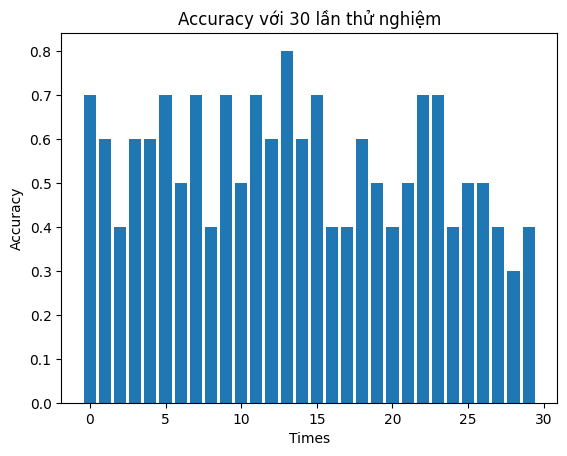

In [72]:
print("Accuracy 30 times = ", list_accuracy)
x = range(len(list_accuracy))
plt.bar(x, list_accuracy)
plt.xlabel('Times')
plt.ylabel('Accuracy')
plt.title('Accuracy với 30 lần thử nghiệm')
plt.show()

In [73]:
logistic_optimize_metrics = [sum(list_accuracy) / len(list_accuracy),
                            sum(list_recall) / len(list_recall),
                            sum(list_f1_score) / len(list_f1_score),
                            sum(list_precision) / len(list_precision)]


In [74]:
column_names = ["","Logistic Regression", "Decision Tree", "Naive Bayes", "Random Forest","Logistic Regression Optimize"]
row_names = ["Accuracy", "Recall", "F1-Score", "Precision", "Average"]
rows = []
for row_name, list1_val, list2_val, list3_val, list4_val,list5_val in zip(row_names, logistic_regress_metrics, decision_tree_metrics, 
                                                     naive_bayes_metrics, random_forest_metrics,logistic_optimize_metrics):
    row = (row_name, list1_val, list2_val, list3_val, list4_val,list5_val)
    rows.append(row)

metrics = spark.createDataFrame(rows, column_names)
metrics.show()

+---------+-------------------+------------------+-------------------+------------------+----------------------------+
|         |Logistic Regression|     Decision Tree|        Naive Bayes|     Random Forest|Logistic Regression Optimize|
+---------+-------------------+------------------+-------------------+------------------+----------------------------+
| Accuracy|               0.53|0.4800000000000001| 0.4766666666666667|0.5666666666666667|          0.5499999999999999|
|   Recall|               0.53|0.4800000000000001|0.47666666666666674|0.5666666666666667|                        0.55|
| F1-Score| 0.5213880378880378|0.4592987382987383| 0.4729931549931551|0.5086493845565053|          0.4812577291989058|
|Precision| 0.5873849206349208|0.4952433862433862| 0.5229126984126984|0.5015978835978836|         0.47665740740740736|
+---------+-------------------+------------------+-------------------+------------------+----------------------------+



Với regParam=0.02, elasticNetParam=0.6 ta có:

In [75]:
def LogisticRegression_Optimize_Func(X_train):
    logit = LogisticRegression(maxIter=10,featuresCol = "Features", labelCol = "Label",regParam=0.02, elasticNetParam=0.6)
    logitModel = logit.fit(X_train)
    return logitModel

In [76]:
matches_df = encoded_matches_label

list_accuracy = []
list_recall = []
list_f1_score = []
list_precision = []
for i in range(0,30):

    X_train = Train_Dataset(matches_df)
    X_train = X_train.select('Features', 'Label')

    X_test = Test_Dataset(matches_df)
    X_test = X_test.select('Features', 'Label')

    logitModel = LogisticRegression_Optimize_Func(X_train)
    predictions = LogitRegres_Predictions(logitModel, X_test)

    accuracy = Measure_Function(predictions, "accuracy")
    recall = Measure_Function(predictions, "weightedRecall")
    f1_score = Measure_Function(predictions, "f1")
    precision = Measure_Function(predictions, "weightedPrecision")

    #print("Accuracy = %g" % accuracy)

    list_accuracy.append(accuracy)
    list_recall.append(recall)
    list_f1_score.append(f1_score)
    list_precision.append(precision)

    matches_df = Reduce_Matches(matches_df)


In [77]:
logistic_optimize_metrics = [sum(list_accuracy) / len(list_accuracy),
                            sum(list_recall) / len(list_recall),
                            sum(list_f1_score) / len(list_f1_score),
                            sum(list_precision) / len(list_precision)]

In [78]:
column_names = ["","Logistic Regression", "Decision Tree", "Naive Bayes", "Random Forest","Logistic Regression Optimize"]
row_names = ["Accuracy", "Recall", "F1-Score", "Precision", "Average"]
rows = []
for row_name, list1_val, list2_val, list3_val, list4_val,list5_val in zip(row_names, logistic_regress_metrics, decision_tree_metrics, 
                                                     naive_bayes_metrics, random_forest_metrics,logistic_optimize_metrics):
    row = (row_name, list1_val, list2_val, list3_val, list4_val,list5_val)
    rows.append(row)

metrics = spark.createDataFrame(rows, column_names)
metrics.show()

+---------+-------------------+------------------+-------------------+------------------+----------------------------+
|         |Logistic Regression|     Decision Tree|        Naive Bayes|     Random Forest|Logistic Regression Optimize|
+---------+-------------------+------------------+-------------------+------------------+----------------------------+
| Accuracy|               0.53|0.4800000000000001| 0.4766666666666667|0.5666666666666667|          0.5366666666666667|
|   Recall|               0.53|0.4800000000000001|0.47666666666666674|0.5666666666666667|          0.5366666666666667|
| F1-Score| 0.5213880378880378|0.4592987382987383| 0.4729931549931551|0.5086493845565053|         0.48224082018199677|
|Precision| 0.5873849206349208|0.4952433862433862| 0.5229126984126984|0.5015978835978836|         0.47511640211640216|
+---------+-------------------+------------------+-------------------+------------------+----------------------------+



Với regParam=0.08, elasticNetParam=0.2 ta có:

In [79]:
def LogisticRegression_Optimize_Func(X_train):
    logit = LogisticRegression(maxIter=10,featuresCol = "Features", labelCol = "Label",regParam=0.08, elasticNetParam=0.2)
    logitModel = logit.fit(X_train)
    return logitModel

In [80]:
matches_df = encoded_matches_label

list_accuracy = []
list_recall = []
list_f1_score = []
list_precision = []
for i in range(0,30):

    X_train = Train_Dataset(matches_df)
    X_train = X_train.select('Features', 'Label')

    X_test = Test_Dataset(matches_df)
    X_test = X_test.select('Features', 'Label')

    logitModel = LogisticRegression_Optimize_Func(X_train)
    predictions = LogitRegres_Predictions(logitModel, X_test)

    accuracy = Measure_Function(predictions, "accuracy")
    recall = Measure_Function(predictions, "weightedRecall")
    f1_score = Measure_Function(predictions, "f1")
    precision = Measure_Function(predictions, "weightedPrecision")

    #print("Accuracy = %g" % accuracy)

    list_accuracy.append(accuracy)
    list_recall.append(recall)
    list_f1_score.append(f1_score)
    list_precision.append(precision)

    matches_df = Reduce_Matches(matches_df)


In [81]:
logistic_optimize_metrics = [sum(list_accuracy) / len(list_accuracy),
                            sum(list_recall) / len(list_recall),
                            sum(list_f1_score) / len(list_f1_score),
                            sum(list_precision) / len(list_precision)]

In [82]:
column_names = ["","Logistic Regression", "Decision Tree", "Naive Bayes", "Random Forest","Logistic Regression Optimize"]
row_names = ["Accuracy", "Recall", "F1-Score", "Precision", "Average"]
rows = []
for row_name, list1_val, list2_val, list3_val, list4_val,list5_val in zip(row_names, logistic_regress_metrics, decision_tree_metrics, 
                                                     naive_bayes_metrics, random_forest_metrics,logistic_optimize_metrics):
    row = (row_name, list1_val, list2_val, list3_val, list4_val,list5_val)
    rows.append(row)

metrics = spark.createDataFrame(rows, column_names)
metrics.show()

+---------+-------------------+------------------+-------------------+------------------+----------------------------+
|         |Logistic Regression|     Decision Tree|        Naive Bayes|     Random Forest|Logistic Regression Optimize|
+---------+-------------------+------------------+-------------------+------------------+----------------------------+
| Accuracy|               0.53|0.4800000000000001| 0.4766666666666667|0.5666666666666667|          0.5499999999999999|
|   Recall|               0.53|0.4800000000000001|0.47666666666666674|0.5666666666666667|          0.5499999999999999|
| F1-Score| 0.5213880378880378|0.4592987382987383| 0.4729931549931551|0.5086493845565053|         0.48831063925181584|
|Precision| 0.5873849206349208|0.4952433862433862| 0.5229126984126984|0.5015978835978836|          0.4762671957671957|
+---------+-------------------+------------------+-------------------+------------------+----------------------------+



Với regParam=0.02, elasticNetParam=0.2 ta có:

In [83]:
def LogisticRegression_Optimize_Func(X_train):
    logit = LogisticRegression(maxIter=10,featuresCol = "Features", labelCol = "Label",regParam=0.02, elasticNetParam=0.2)
    logitModel = logit.fit(X_train)
    return logitModel

In [84]:
logistic_optimize_metrics = [sum(list_accuracy) / len(list_accuracy),
                            sum(list_recall) / len(list_recall),
                            sum(list_f1_score) / len(list_f1_score),
                            sum(list_precision) / len(list_precision)]

In [85]:
column_names = ["","Logistic Regression", "Decision Tree", "Naive Bayes", "Random Forest","Logistic Regression Optimize"]
row_names = ["Accuracy", "Recall", "F1-Score", "Precision", "Average"]
rows = []
for row_name, list1_val, list2_val, list3_val, list4_val,list5_val in zip(row_names, logistic_regress_metrics, decision_tree_metrics, 
                                                     naive_bayes_metrics, random_forest_metrics,logistic_optimize_metrics):
    row = (row_name, list1_val, list2_val, list3_val, list4_val,list5_val)
    rows.append(row)

metrics = spark.createDataFrame(rows, column_names)
metrics.show()

+---------+-------------------+------------------+-------------------+------------------+----------------------------+
|         |Logistic Regression|     Decision Tree|        Naive Bayes|     Random Forest|Logistic Regression Optimize|
+---------+-------------------+------------------+-------------------+------------------+----------------------------+
| Accuracy|               0.53|0.4800000000000001| 0.4766666666666667|0.5666666666666667|          0.5499999999999999|
|   Recall|               0.53|0.4800000000000001|0.47666666666666674|0.5666666666666667|          0.5499999999999999|
| F1-Score| 0.5213880378880378|0.4592987382987383| 0.4729931549931551|0.5086493845565053|         0.48831063925181584|
|Precision| 0.5873849206349208|0.4952433862433862| 0.5229126984126984|0.5015978835978836|          0.4762671957671957|
+---------+-------------------+------------------+-------------------+------------------+----------------------------+



Test các trận đấu mới nhất

In [39]:
matches_df = encoded_matches_label
matches_df.show(15)

+--------+----------+--------------------+-------------------+------------------+--------------+---------------+----------+------------+------------+----------------+---------------+-------------+---------------+--------------+---------------+------------------------+------------+--------+--------+-------+-----------+-------+--------+---------+---------+------------+--------+--------+-----------+------------------+------------------+------------------+--------+--------+---------------+---------------+-----------------------+----------------+--------------------+-----------------+-----------------+------------------+--------------------+----------------+----------------+--------------+---------------+----------+------------+------------+----------------+---------------+-------------+---------------+--------------+---------------+------------------------+------------+--------+--------+-------+-----------+-------+--------+---------+---------+------------+--------+--------+-----------+----

In [41]:
X_train = matches_df
X_train = X_train.select('Features', 'Label')

X_test = Test_Dataset(matches_df)
X_test = X_test.select('Features', 'Label')

logitModel = LogisticRegression_Func(X_train)
predictions = LogitRegres_Predictions(logitModel, X_test)

In [43]:
predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            Features|Label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(171,[0,1,2,3,4,5...|  0.0|[1.63849564119624...|[0.84385716289338...|       0.0|
|(171,[0,1,2,3,4,5...|  0.0|[1.20539610987106...|[0.73788932668688...|       0.0|
|(171,[0,1,2,3,4,5...|  1.0|[-0.0458701241649...|[0.18764886127730...|       1.0|
|(171,[0,1,2,3,4,5...|  0.0|[0.80044536466485...|[0.60632772029995...|       0.0|
|(171,[0,1,2,3,4,5...|  0.0|[2.12897341791698...|[0.90138928042122...|       0.0|
|(171,[0,1,2,3,4,5...|  1.0|[0.43504181097536...|[0.44227915943242...|       0.0|
|(171,[0,1,2,3,4,5...|  2.0|[-0.4524914090107...|[0.19560238464125...|       2.0|
|(171,[0,1,2,3,4,5...|  0.0|[0.96622283493879...|[0.58330256552696...|       0.0|
|(171,[0,1,2,3,4,5...|  2.0|[0.17384290823301...|[0.37780958521862...|       2.0|
|(171,[0,1,2,3,4